In [2]:
## ALL IMPORTS FOR A NEW NOTEBOOK
__SEED = 0
__N_FOLDS = 5
__NROWS = None

import os, sys, random, math
import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('ggplot')

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import ml_utils as mu
import time
import time, datetime, pickle


# fold1 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED)
# fold2 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED+3)
# fold3 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED+5)
font = {'size'   : 14}
matplotlib.rc('font', **font)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(947)

## UTILS.py

In [3]:
## boundary coords: (x_min, y_min, x_max, y_max) --> xy
## center-size coords: (c_x, c_y, w, h) --> cxcy
## encoded coords: (gc_x, gc_y, gc_w, gc_h) --> gcxgcy


def cxcy_to_xy(cxcy):
    return torch.cat([
        cxcy[:,:2] - (cxcy[:,2:]/2.0),
        cxcy[:,:2]+(cxcy[:,2:]/2.0)
    ],dim=1)

def xy_to_cxcy(xy):
    return torch.cat([
        (xy[:,:2]+xy[:,:2])/2,
        (xy[:,2:]-xy[:,:2])
    ],dim=1)

def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    return torch.cat([
        (cxcy[:,:2]-priors_cxcy[:,:2])/(priors_cxcy[:,2:]/10.0),
        torch.log((cxcy[:,2:]/priors_cxcy[:,2:])*5.0)
    ], dim=1)

def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    return torch.cat([
        gcxgcy[:, :2]*priors_cxcy[:,2:]/10.0 + priors_cxcy[:,:2],
        torch.exp((gcxgcy[:,2:]/5.0)*priors_cxcy[:,2:])
    ],dim=1)

In [4]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum/self.count

In [5]:
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                nn.utils.clip_grad_norm_(param, grad_clip)

In [6]:
def save_checkpoint(epoch, model, optimizer):
    state = {'epoch':epoch, 'model_state':model.state_dict(), 'optimizer':optimizer}
    filename = 'checkpoint_ssd300.pth.tar'
    torch.save(state, filename)

In [7]:
def adjust_learning_rate(optimizer, scale):
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr']*scale
    print("DECAYING LR\nNew LR is: {}".format(optimizer.param_groups[1]['lr']))

In [8]:
def decimate(tensor, m):
    assert tensor.dim() == len(m)
    
    print("Decimating Tensor of shape: ",tensor.shape)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(dim=d, index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())
    print("Decimated to Tensor of shape: ",tensor.shape)
    return tensor

In [9]:
def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties):
    assert(len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(true_labels) == len(true_difficulties))
    n_classes = len(label_map)
    
    
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i]*true_labels[i].size(0))
    true_images = torch.LongTensor(true_images).to(device)
    true_boxes = torch.cat(true_boxes, dim=0)
    true_labels = torch.cat(true_labels, dim=0)
    true_difficulties = torch.cat(true_difficulties, dim=0)
    assert true_images.size(0) == true_labels.size(0) == true_boxes.size(0)
    
    
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i]*det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)
    det_boxes = torch.cat(det_boxes, dim=0)
    det_labels = torch.cat(det_labels, dim=0)
    det_scores = torch.cat(det_scores, dim=0)
    assert det_images.size(0) == det_labels.size(0) == det_scores.size(0)
    
    
    
    average_precisions = torch.zeros((n_classes-1), dtype=torch.float)
    
    for c in tqdm(range(1, n_classes)):
        true_class_images = true_images[true_labels == c]
        true_class_boxes = true_boxes[true_labels == c]
        true_class_difficulties = true_difficulties[true_labels == c]
        n_easy_class_objects = (1-true_class_difficulties).sum().item()
        
        
        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.bool).to(device)
        
        det_class_images = det_images[det_labels == c]
        det_class_boxes = det_boxes[det_labels == c]
        det_class_scores = det_scores[det_labels == c]
        n_class_detections = det_class_boxes.size(0)
        
        if n_class_detections == 0:
            continue
        
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)
        det_class_images = det_class_images[sort_ind]
        det_class_boxes = det_class_boxes[sort_ind]
        
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)
        
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)
            this_image = det_class_images[d]
            
            object_boxes = true_class_boxes[true_class_images == this_image]
            object_difficulties = true_class_difficulties[true_class_images == this_image]
            
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue
            
            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)
            
            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            
            if max_overlap.item()>0.5:
                if object_difficulties[ind] == 0:
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = 1
                    else:
                        false_positives[d] = 1
            else:
                false_positives[d] = 1
            
        cumulative_tps = torch.cumsum(true_positives, dim=0)
        cumulative_fps = torch.cumsum(false_positives, dim=0)
        cumulative_precision = cumulative_tps/(cumulative_tps+cumulative_fps+1e-16)
        cumulative_recall = cumulative_tps/(n_easy_class_objects+1e-16)
        
        
        recall_thresholds = torch.arange(start=0, end=1.1, step=0.1).tolist()
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)
        
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumulative_recall>=t
            if recalls_above_t.any():
                precisions[i] = cumulative_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.0
        
        average_precisions[c-1] = precisions.mean()
    
    mean_average_precision = average_precisions.mean().item()
    
    average_precisions = {rev_label_map[c+1]:v for c,v in enumerate(average_precisions.tolist())}
    
    return average_precisions, mean_average_precision

In [10]:
voc_labels = ["aeroplane","bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", 
              "diningtable","dog","horse","motorbike","person", "train","pottedplant",
              "sheep","sofa","tvmonitor"]

label_map = {k:v+1 for v,k in enumerate(voc_labels)}
label_map["background"] = 0
rev_label_map = {v:k for k,v in label_map.items()}

distinct_colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                   '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabebe',
                   '#469990', '#e6beff', '#9A6324', '#fffac8', '#800000',
                   '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9',"#FFFFFF"]

label_color_map = {k:distinct_colors[i] for i,k in enumerate(label_map.keys())}

In [11]:
from xml.etree import ElementTree as ET
import json

### FOR PARSING THE XML ANNOTATIONS OF THE DATASETS ###
def parse_annotations(annotation_path):
    tree = ET.parse(annotation_path)
    
    root = tree.getroot()
    
    boxes = list()
    labels = list()
    difficulties = list()
    
    for object in root.iter('object'):
        difficult = int(object.find("difficult").text=="1")
        label = object.find("name").text.lower().strip()
        
        if label not in label_map:
            continue
        
        bbox = object.find('bndbox')
        xmin = int(bbox.find('xmin').text) - 1
        xmax = int(bbox.find('xmax').text) - 1
        ymin = int(bbox.find('ymin').text) - 1
        ymax = int(bbox.find('ymax').text) - 1
        
        boxes.append([xmin,ymin,xmax,ymax])
        labels.append(label_map[label])
        difficulties.append(difficult)
    return {"boxes":boxes, "labels":labels,"difficulties":difficulties}

In [12]:
### READ XML DESCRIPTIONS AND SAVE AS JSON FOR FASTER ACCESS ###
def create_data_lists(v07, v12, output_folder):
    v07_path = os.path.abspath(v07)
    v12_path = os.path.abspath(v12)
    
    ## PARSE TRAIN ##
    train_images = list()
    train_objects = list()
    n_objects = 0
    
    for path in [v07_path, v12_path]:
        with open(os.path.join(path,"ImageSets/Main/trainval.txt")) as f:
            ids = f.read().splitlines()
            
            for id in ids:
                objects = parse_annotations(os.path.join(path,"Annotations",id+".xml"))
                
                if len(objects["boxes"])==0:
                    continue
                n_objects+=len(objects["boxes"])
                
                train_objects.append(objects)
                train_images.append(os.path.join(path, "JPEGImages", id+'.jpg'))
                
        
    print("TOTAL TRAIN IMAGES: {} == TOTAL TRAIN OBJECTS {}".format(len(train_images), len(train_objects)))
    print("TOTAL OBJECTS IN ALL TRAIN IMAGES: {}\n".format(n_objects))
    
    with open(os.path.join(output_folder, "TRAIN_images.json"), 'w') as j:
        json.dump(train_images, j)
    with open(os.path.join(output_folder, "TRAIN_objects.json"), 'w') as j:
        json.dump(train_objects, j)
    with open(os.path.join(output_folder, "label_map.json"), 'w') as j:
        json.dump(label_map, j)
    
    
    ## PARSE TEST ##
    
    test_images = list()
    test_objects = list()
    n_objects = 0
    
    with open(os.path.join(v07_path, "ImageSets/Main/test.txt")) as f:
        ids = f.read().splitlines()
        
        for id in ids:
            objects = parse_annotations(os.path.join(v07_path, "Annotations", id+".xml"))
            
            if (len(objects["boxes"]))==0:
                continue
            test_objects.append(objects)
            test_images.append(os.path.join(v07_path,"JPEGImages",id+'.jpg'))
            n_objects+=len(objects['boxes'])
        
    print("TOTAL TEST IMAGES: {} == TOTAL TEST OBJECTS {}".format(len(test_images), len(test_objects)))
    print("TOTAL OBJECTS IN ALL TEST IMAGES: {}\n".format(n_objects))
    
    with open(os.path.join(output_folder, "TEST_images.json"), 'w') as j:
        json.dump(test_images, j)
    with open(os.path.join(output_folder, "TEST_objects.json"), 'w') as j:
        json.dump(test_objects, j)

In [13]:
from torchvision.transforms import functional as FT
def photometric_distort(image):
    """
    Distort brightness, contrast, saturation and hue, each with a 50% chance in random order
    
    """
    new_image = image
    distortions = [FT.adjust_brightness, FT.adjust_contrast, FT.adjust_saturation, FT.adjust_hue]
    
    random.shuffle(distortions)
    
    for d in distortions:
        if random.random()<0.5:
            if d.__name__ is "adjust_hue":
                adjust_factor = random.uniform(-18/255.0, 18/255.0)
            else:
                adjust_factor = random.uniform(0.5, 1.5)
            
            new_image = d(new_image, adjust_factor)
    
    return new_image

In [14]:
def expand(image, boxes, filler):
    """
    Zooming out by placing the image in a larger canvas of filler material.
    Helps to detect smaller objects.
    """
    
    original_h = image.size(1)
    original_w = image.size(2)
    
    max_scale = 4
    scale = random.uniform(1,max_scale)
    new_h = int(scale*original_h)
    new_w = int(scale*original_w)
    
    filler = torch.FloatTensor(filler)
    
    ## elementwise product to initialize the new image with all filler
    new_image = torch.ones((3,new_h, new_w), dtype=torch.float)*filler.unsqueeze(1).unsqueeze(1)
    
    ## place the original image in random coordinate in the new expnded image
    left = random.randint(0, new_w-original_w)
    right = left+original_w
    top = random.randint(0,new_h-original_h)
    bottom = top+original_h
    new_image[:, top:bottom, left:right] = image
    
    ## update bbox locations
    new_boxes = boxes+torch.FloatTensor([left, top, left, top]).unsqueeze(0)
    
    return new_image, new_boxes

In [15]:
def find_intersection(set1, set2):
    lower_bounds = torch.max(set1[:,:2].unsqueeze(1), set2[:,:2].unsqueeze(0)) # n1 X n2 X 2
    upper_bounds = torch.min(set1[:,2:].unsqueeze(1), set2[:,2:].unsqueeze(0)) # n1 X n2 X 2
    
    intersection_dims = torch.clamp(upper_bounds-lower_bounds, min=0) # just to make sure there're no -ves
    
    return intersection_dims[:,:,1]*intersection_dims[:,:,0] # one is height, another is width

def find_jaccard_overlap(set1, set2):
    """
    set1, set2 --> n1X4, n2X4
    output --> n1Xn2
    """
    
    intersection = find_intersection(set1, set2) # n1 x n2
    
    areas_set1 = (set1[:,2]-set1[:,0])*(set1[:,3]-set1[:,1]) # n1
    areas_set2 = (set2[:,2]-set2[:,0])*(set2[:,3]-set2[:,1]) # n2
    
    union = areas_set1.unsqueeze(1)+areas_set2.unsqueeze(0)-intersection # n1 X n2
    
    return intersection/union

In [16]:
def random_crop(image, boxes, labels, difficulties):
    """
    Helps to detect larger and partial objects
    """
    
    original_h = image.size(1)
    original_w = image.size(2)
    
    # Keep choosing minimum overlap until a successful crop is made
    while True:
        min_overlap = random.choice([0.0, 0.1, 0.3, 0.5, 0.7, 0.8, None])
        
        if min_overlap is None:
            return image, boxes, labels, difficulties
        
        # try up to 50 times for this choice of minimum overlap
        
        max_trials = 50
        for _ in range(max_trials):
            min_scale = 0.3 # crop dimension
            
            scale_h = random.uniform(min_scale, 1)
            scale_w = random.uniform(min_scale, 1)
            
            new_h = int(scale_h*original_h)
            new_w = int(scale_w*original_w)
            
            aspect_ratio = new_h/new_w
            
            # aspect ratio must be within 0.5 ~ 2 for our implementation
            if not 0.5<aspect_ratio<2:
                continue
            
            left = random.randint(0, original_w - new_w)
            right = left + new_w
            top = random.randint(0, original_h - new_h)
            bottom = top + new_h
            crop = torch.FloatTensor([left, top, right, bottom])

            # Find jaccard overlap between the boxes and crop section, if there're no boxes with minimum jaccard
            # overlap needed, try again....50 times
            overlap = find_jaccard_overlap(crop.unsqueeze(0), boxes) # make sure intersection dimension is in n1X4 
            overlap = overlap.squeeze(0) # for getting the n objects
            
            if overlap.max().item()<min_overlap:
                continue
            
            new_image = image[:, top:bottom, left:right]
            
            ## original bb centers
            bb_centers = (boxes[:,:2]+boxes[:,2:])/2.0 # nobs X 2
            
            centers_in_crop = (bb_centers[:,0]>left)*(bb_centers[:,0]<right)*(bb_centers[:,1]>top)*(bb_centers[:,1]<bottom)
            
            if not centers_in_crop.any():
                continue
            
            new_boxes = boxes[centers_in_crop]
            new_labels = labels[centers_in_crop]
            new_difficulties = difficulties[centers_in_crop]
            
            new_boxes[:,:2] = torch.max(new_boxes[:,:2], crop[:2])
            new_boxes[:,:2] -= crop[:2] # adjust the new boxes wrt new image
            new_boxes[:,2:] = torch.min(new_boxes[:,2:], crop[2:])
            new_boxes[:,2:] -= crop[:2]
            
            return new_image, new_boxes, new_labels, new_difficulties

In [17]:
def flip(image, boxes):
    new_image = FT.hflip(image)
    
    new_boxes = boxes
    new_boxes[:,0] = image.width-boxes[:,0]-1
    new_boxes[:,2] = image.width-boxes[:,2]-1
    new_boxes = new_boxes[:,[2,1,0,3]]
    return new_image, new_boxes

def resize(image, boxes, dims=(300,300), return_percent_coords=True):
    new_image = FT.resize(image, dims)
    
    old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
    new_boxes = boxes/old_dims
    
    if not return_percent_coords:
        new_dims = torch.FloatTensor([dims[1],dims[0],dims[1],dims[0]]).unsqueeze(0)
        new_boxes = new_boxes*new_dims
    
    return new_image, new_boxes

In [34]:
def transform(image, boxes, labels, difficulties, split):
    assert split in {"TRAIN", "TEST"}
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    new_image = image
    new_boxes = boxes
    new_labels = labels
    new_difficulties = difficulties
    
    if split == "TRAIN":
        new_image = photometric_distort(new_image)
        new_image = FT.to_tensor(new_image)
        
        ## ZOOM OUT
        if random.random()<0.5:
            new_image, new_boxes = expand(new_image, boxes, filler=mean)
        
        ## ZOOM IN
        new_image, new_boxes, new_labels, new_difficulties = random_crop(new_image, new_boxes, new_labels,
                                                                         new_difficulties)
        
        new_image = FT.to_pil_image(new_image)
        
        if random.random()<0.5:
            new_image, new_boxes = flip(new_image, new_boxes)
    print((new_boxes<0.0).any().sum())
    new_image, new_boxes = resize(new_image, new_boxes)
    new_image = FT.to_tensor(new_image)
    
    new_image = FT.normalize(new_image, mean=mean, std=std)
        
    return new_image, new_boxes, new_labels, new_difficulties

In [35]:
# %%time
# create_data_lists(v07='./train/VOC2007/',
#                       v12='./train/VOC2012',
#                       output_folder='./')

In [36]:
train_dataset = PascalVOCDataset(data_folder, split='train', keep_diffcult=True)
train_loader = DataLoader(train_dataset, batch_size=2, collate_fn=train_dataset.collate_fn,
                          shuffle=True, num_workers=num_workers, pin_memory=pin_memory)


In [37]:
for b in train_loader:
    break

tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)


# DATASETS.py

In [20]:
from PIL import Image

class PascalVOCDataset(Dataset):
    def __init__(self, data_folder, split, keep_diffcult=False):
        self.split = split.upper()
        assert self.split in {"TRAIN", "TEST"}
        
        self.data_folder = data_folder
        self.keep_difficult = keep_diffcult
        
        with open(os.path.join(data_folder, self.split+"_images.json"),'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split+"_objects.json"), 'r') as j:
            self.objects = json.load(j)
        assert len(self.images) == len(self.objects)
    
    def __getitem__(self, i):
        image = Image.open(self.images[i], mode='r')
        image = image.convert("RGB")
        
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects["boxes"]) # n_obs X 4
        labels = torch.LongTensor(objects["labels"]) # n_obs
        difficulties = torch.ByteTensor(objects["difficulties"]) # n_obs
    
        if not self.keep_difficult:
            boxes = boxes[1-difficulties]
            labels = labels[1-difficulties]
            difficulties = difficulties[1-difficulties]
        
        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, split=self.split)
        
        return image, boxes, labels, difficulties
    
    def __len__(self):
        return len(self.images)
    
    def collate_fn(self, batch):
        """
        Each image may have different number of objects and so,
        we need to provide a function to combine these tensors of different sizes.
        """
        
        images = list()
        boxes = list()
        labels = list()
        difficulties = list()
        
        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])
        images = torch.stack(images, dim=0)
        
        return images, boxes, labels, difficulties # tensor (N, 3, 300, 300) and 3 lists of N tensors each

# model.py

In [21]:
import torchvision

class VGGBase(nn.Module):
    
    def __init__(self):
        super(VGGBase, self).__init__()
        
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5_1 = nn.Conv2d(512,512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512,512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512,512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
        
        self.load_pretrained_layers()
    
    def forward(self, image):
        out = F.relu(self.conv1_1(image))
        out = F.relu(self.conv1_2(out))
        out = self.pool1(out)
        
        out = F.relu(self.conv2_1(out))
        out = F.relu(self.conv2_2(out))
        out = self.pool2(out)
        
        out = F.relu(self.conv3_1(out))
        out = F.relu(self.conv3_2(out))
        out = F.relu(self.conv3_3(out))
        out = self.pool3(out)
        
        out = F.relu(self.conv4_1(out))
        out = F.relu(self.conv4_2(out))
        out = F.relu(self.conv4_3(out))
        conv_4_3_feats = out
        out = self.pool4(out)
        
        out = F.relu(self.conv5_1(out))
        out = F.relu(self.conv5_2(out))
        out = F.relu(self.conv5_3(out))
        out = self.pool5(out)
        
        out = F.relu(self.conv6(out))
        out = F.relu(self.conv7(out))
        
        conv7_feats = out
        
        return conv_4_3_feats, conv7_feats
    
    def load_pretrained_layers(self):
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())
        
        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())
        
        ## LOADING FIRST UNCHANGED LAYERS' WEIGHTS
        for i, param in enumerate(param_names[:-4]):
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]
        
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4,None, 3, 3])
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])
        
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096,4096,1,1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4,4,None,None])
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])
        
        self.load_state_dict(state_dict)
        
        print("BASE MODEL LOAD....COMPLETE\n")

In [22]:
class AuxiliaryConvolutions(nn.Module):
    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()
        
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=2)
        
        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2)
        
        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)
        
        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)
        
        
        self.init_conv2d()
    
    def init_conv2d(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.0)
    
    def forward(self, conv7_feats):
        out = F.relu(self.conv8_1(conv7_feats))
        out = F.relu(self.conv8_2(out))
        conv8_2_feats = out
        
        out = F.relu(self.conv9_1(out))
        out = F.relu(self.conv9_2(out))
        conv9_2_feats = out
        
        out = F.relu(self.conv10_1(out))
        out = F.relu(self.conv10_2(out))
        conv10_2_feats = out
        
        out = F.relu(self.conv11_1(out))
        out = F.relu(self.conv11_2(out))
        conv11_2_feats = out
        
        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats

In [23]:
class PredictionConvolutions(nn.Module):
    def __init__(self, n_classes):
        super(PredictionConvolutions, self).__init__()
        
        self.n_classes = n_classes
        
        n_boxes = {
            'conv4_3':4,
            'conv7':6,
            'conv8_2':6,
            'conv9_2':6,
            'conv10_2':4,
            'conv11_2':4
        }
        
        
        self.loc_conv4_3 = nn.Conv2d(512, 4*n_boxes['conv4_3'], kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, 4*n_boxes['conv7'], kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, 4*n_boxes['conv8_2'], kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, 4*n_boxes['conv9_2'], kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, 4*n_boxes['conv10_2'], kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, 4*n_boxes['conv11_2'], kernel_size=3, padding=1)
        
        
        self.cl_conv4_3 = nn.Conv2d(512, self.n_classes*n_boxes['conv4_3'], kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, self.n_classes*n_boxes['conv7'], kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, self.n_classes*n_boxes['conv8_2'], kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, self.n_classes*n_boxes['conv9_2'], kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, self.n_classes*n_boxes['conv10_2'], kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, self.n_classes*n_boxes['conv11_2'], kernel_size=3, padding=1)
        
        self.init_conv2d()
    
    def init_conv2d(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.0)
                
    
    
    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        
        batch_size = conv4_3_feats.size(0)
        
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats).permute(0,2,3,1).contiguous().view(batch_size, -1, 4)
        l_conv7 = self.loc_conv7(conv7_feats).permute(0,2,3,1).contiguous().view(batch_size, -1, 4)
        l_conv8_2 = self.loc_conv8_2(conv8_2_feats).permute(0,2,3,1).contiguous().view(batch_size, -1, 4)
        l_conv9_2 = self.loc_conv9_2(conv9_2_feats).permute(0,2,3,1).contiguous().view(batch_size, -1, 4)
        l_conv10_2 = self.loc_conv10_2(conv10_2_feats).permute(0,2,3,1).contiguous().view(batch_size, -1, 4)
        l_conv11_2 = self.loc_conv11_2(conv11_2_feats).permute(0,2,3,1).contiguous().view(batch_size, -1, 4)
        
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)
        
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats).permute(0,2,3,1).contiguous().view(batch_size, -1, self.n_classes)
        c_conv7 = self.cl_conv7(conv7_feats).permute(0,2,3,1).contiguous().view(batch_size, -1, self.n_classes)
        c_conv8_2 = self.cl_conv8_2(conv8_2_feats).permute(0,2,3,1).contiguous().view(batch_size, -1, self.n_classes)
        c_conv9_2 = self.cl_conv9_2(conv9_2_feats).permute(0,2,3,1).contiguous().view(batch_size, -1, self.n_classes)
        c_conv10_2 = self.cl_conv10_2(conv10_2_feats).permute(0,2,3,1).contiguous().view(batch_size, -1, self.n_classes)
        c_conv11_2 = self.cl_conv11_2(conv11_2_feats).permute(0,2,3,1).contiguous().view(batch_size, -1, self.n_classes)
        
        class_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2], dim=1)
        
        return locs, class_scores

In [24]:
from math import sqrt

class SSD300(nn.Module):
    def __init__(self, n_classes):
        super(SSD300, self).__init__()
        self.n_classes = n_classes
        
        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)
        
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))
        nn.init.constant_(self.rescale_factors, 20)
        
        self.priors_cxcy = self.create_prior_boxes()
    
    def create_prior_boxes(self):
        fmap_dims = {
            "conv4_3":38,
            "conv7":19,
            "conv8_2":10,
            "conv9_2":5,
            "conv10_2":3,
            "conv11_2":1
        }
        obj_scales = {
            "conv4_3":0.1,
            "conv7":0.2,
            "conv8_2":0.375,
            "conv9_2":0.55,
            "conv10_2":0.725,
            "conv11_2":0.9
        }
        aspect_ratios = {
            "conv4_3":[1.0,2.0,0.5],
            "conv7":[1.0,2.0,0.5,3.0,.33],
            "conv8_2":[1.0,2.0,0.5,3.0,.33],
            "conv9_2":[1.0,2.0,0.5,3.0,.33],
            "conv10_2":[1.0,2.0,0.5],
            "conv11_2":[1.0,2.0,0.5]
        }
        
        fmaps = list(fmap_dims.keys())
        
        prior_boxes = []
        
        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j+0.5)/fmap_dims[fmap]
                    cy = (i+0.5)/fmap_dims[fmap]
                    
                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx,cy,obj_scales[fmap]*sqrt(ratio), obj_scales[fmap]/sqrt(ratio)])
                        
                        if ratio==1:
                            try:
                                additional_scale = sqrt(obj_scales[fmap]*obj_scales[fmaps[k+1]])
                            except IndexError:
                                additional_scale = 1
                            
                            prior_boxes.append([cx,cy,additional_scale, additional_scale])
        
        prior_boxes = torch.FloatTensor(prior_boxes).to(device)
        prior_boxes.clamp_(0, 1)
        
        return prior_boxes
    
    def forward(self, image):
        conv4_3_feats, conv7_feats = self.base(image)
        norm = conv4_3_feats.norm(dim=1, keepdim=True)+1e-16
        conv4_3_feats = conv4_3_feats/norm
        conv4_3_feats = conv4_3_feats*self.rescale_factors
        
        
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = self.aux_convs(conv7_feats)
        
        locs, class_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats)
        
        return locs, class_scores
    
    
    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        
        predicted_scores = F.softmax(predicted_scores, dim=-1)
        
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()
        
        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)
        
        
        for i in range(batch_size):
            decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))
            
            image_boxes = list()
            image_labels = list()
            image_scores = list()
            
#             max_scores, best_label = predicted_scores[i].max(dim=1)
            
            for c in range(1, self.n_classes):
                class_scores  = predicted_scores[i][:, c] # 8732
                scores_above_min_score = class_scores > min_score # 8732, True or False
                n_above_min_score = scores_above_min_score.sum().item() # 1
                
                if n_above_min_score == 0:
                    continue
                
                # valid scores
                class_scores = class_scores[scores_above_min_score] # N_QLF
                # boxes with valid scores
                class_decoded_locs = decoded_locs[scores_above_min_score] # N_QLF X 4
                
                class_scores, sort_ind = class_scores.sort(descending=True)
                class_decoded_locs = class_decoded_locs[sort_ind]
                
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)
                
                suppress = torch.zeros((n_above_min_score), dtype=torch.bool).to(device)
                
                for box in range(class_decoded_locs.size(0)):
                    if suppress[box] == True:
                        continue
                    suppress = torch.max(suppress, overlap[box]> max_overlap)
                    suppress[box] = False
                
                image_boxes.append(class_decoded_locs[~suppress])
                image_labels.append(torch.LongTensor((~suppress).sum().item()*[c]).to(device))
                image_scores.append(class_scores[~suppress])
            
            if len(image_boxes)==0:
                image_boxes.append(torch.FloatTensor([[0.0,0.0,1.0,1.0]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.0]).to(device))
            
            image_boxes = torch.cat(image_boxes, dim=0)
            image_labels = torch.cat(image_labels, dim=0)
            image_scores = torch.cat(image_scores, dim=0)
            
            n_objects = image_scores.size(0)
            
            
            if n_objects>top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]
                image_boxes = image_boxes[sort_ind][:top_k]
                image_labels = image_labels[sort_ind][:top_k]
            
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)
        
        return all_images_boxes, all_images_labels, all_images_scores

In [25]:
class MultiBoxLoss(nn.Module):
    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.0):
        super(MultiBoxLoss, self).__init__()
        
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha
        
        ## smooth??
        self.smooth_l1 = nn.SmoothL1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')
    
    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)
        
        assert n_priors == predicted_locs.size(1) == predicted_locs.size(1)
        
        ## place holders for each image's true labels and boxes
        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)
        
        # for each image, generate ground truth object class and locations using the priors, i.e. wrt of priors
        for i in range(batch_size):
            n_objects = boxes[i].size(0)
            
            overlap = find_jaccard_overlap(boxes[i], self.priors_xy)
            
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)
            
            overlap_for_each_object, prior_for_each_object = overlap.max(dim=1)
            
            ## What an engineering solution to solve a corner case!!
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)
            overlap_for_each_prior[prior_for_each_object] = 1.0
            
            ## assign object for each prior from the true labels
            label_for_each_prior = labels[i][object_for_each_prior]
            ## remove the object assignments for less than threshold overlap
            label_for_each_prior[overlap_for_each_prior<self.threshold] = 0
            
            ## save the true classes  and locs
            true_classes[i] = label_for_each_prior
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)
        
        
        # find the priors with an object for all batches of images
        positive_priors = true_classes!=0
        
        ## localization loss
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])
        
        
        ## confidence loss
        n_positives = positive_priors.sum(dim=1) # dim=1, because positive_priors is in shape: (batch, 8732)
        n_hard_negatives = self.neg_pos_ratio*n_positives
        
        ## find cross entropy for all predictions
        conf_loss_all = self.cross_entropy(
            predicted_scores.view(-1, n_classes), 
            true_classes.view(-1)
        ).view(batch_size, n_priors) ## (batch_size, 8732)
        
        
        conf_loss_pos = conf_loss_all[positive_priors]
        
        conf_loss_neg = conf_loss_all.clone()
        conf_loss_neg[positive_priors] = 0
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)
        
        # this is basically masking out the n_hard_negatives from each image in the batch, 
        # we could've done it in a easier way
        hardness_rank = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)
        hard_negatives = hardness_rank < n_hard_negatives.unsqueeze(dim=1)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]
        
        conf_loss = (conf_loss_hard_neg.sum()+conf_loss_pos.sum())/n_positives.sum().float()
        
        total_loss = conf_loss+self.alpha*loc_loss
        
        if (total_loss!=total_loss).any():
            file_name = "ERR.txt"
            print("MODEL PARAMS", file=open(file_name, "a"))
            print(model.named_parameters(), file=open(file_name, "a"))
            print("LOC LOSS", file=open(file_name, "a"))
            print(loc_loss, file=open(file_name, "a"))
            print("CONF LOSS ALL", file=open(file_name, "a"))
            print(conf_loss_all, file=open(file_name, "a"))
            print("CONF LOSS POS", file=open(file_name, "a"))
            print(conf_loss_pos, file=open(file_name, "a"))
            print("CONF LOSS HARD NEG", file=open(file_name, "a"))
            print(conf_loss_hard_neg, file=open(file_name, "a"))
            print("TRUE LOCS", file=open(file_name, "a"))
            print(true_locs, file=open(file_name, "a"))
        return total_loss

# train.py

In [26]:
data_folder = "./"
keep_difficult = True

n_classes = len(label_map)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint ="checkpoint_ssd300.pth.tar"
batch_size = 16
iterations = 120000
num_workers = 7
pin_memory = False
print_freq = 200
lr = 5e-4
decay_lr_at = [40000, 80000,100000]
decay_lr_to = 0.5
momentum = 0.9
weight_decay = 5e-4
grad_clip = 0.5

torch.backends.cudnn.benchmark=True

history = pd.DataFrame()
all_epoch_losses = []

model = None

In [27]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [28]:
from tqdm.notebook import tqdm
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    l=0.0
    ll = []
    for i, (images, boxes, labels, _) in enumerate(tqdm(train_loader)):
        
        images = images.to(device)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        
        predicted_locs, predicted_scores = model(images)
        
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)
        l+=loss.item()        

        ll.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        
        plot_grad_flow(model.named_parameters())
        
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)
        optimizer.step()
        
    del predicted_locs, predicted_scores, images, boxes, labels
    plt.savefig("./grads/EPOCH_"+str(epoch)+'.png', bbox_inches='tight')
    plt.close()
    all_epoch_losses.append(ll)
    return l/len(train_loader)

In [29]:
def main():
    """
    Training
    """
    
    global start_epoch, label_map, epoch, checkpoint, decay_lr_at, history, model
    
    model = SSD300(n_classes=n_classes)
    
    if checkpoint is None:
        start_epoch = 0    
        biases = list()
        not_biases = list()
        
        for param_name, param in model.named_parameters():
            if param_name.endswith(".bias"):
                biases.append(param)
            else:
                not_biases.append(param)
        
        optimizer = mu.RAdam(params=[{'params':biases, 'lr':2*lr}, {'params':not_biases}], lr=lr, weight_decay=weight_decay)
    else:
        ## FOR RESUMING TRAINING
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch']+1
        print("\nLoaded checkpoint from epoch {}.\n".format(start_epoch))
        
        model.load_state_dict(checkpoint['model_state'])
        optimizer = checkpoint['optimizer']
    
    
    model = model.to(device)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)
    
    train_dataset = PascalVOCDataset(data_folder, split='train', keep_diffcult=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=train_dataset.collate_fn,
                              shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    
    epochs = 1+iterations//(len(train_dataset)//batch_size)
    decay_lr_at = [it//(len(train_dataset)//batch_size) for it in decay_lr_at]
    decay_lr_at.append(86)
    
    st = time.time()
    
    print("Training For: {} epochs".format(epochs))
    print("Decay Learning Rate AT: ", decay_lr_at)
    
    
    for epoch in range(start_epoch, epochs):
        st = time.time()
        if epoch in decay_lr_at:
            adjust_learning_rate(optimizer, decay_lr_to)
        
        loss = train(train_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, epoch=epoch)
        
        mu.print_epoch_stat(epoch, time.time()-st, train_loss=loss, history=history)
        save_checkpoint(epoch, model, optimizer)
        mu.clear_cuda()

Decimating Tensor of shape:  torch.Size([4096, 512, 7, 7])
Decimated to Tensor of shape:  torch.Size([1024, 512, 3, 3])
Decimating Tensor of shape:  torch.Size([4096])
Decimated to Tensor of shape:  torch.Size([1024])
Decimating Tensor of shape:  torch.Size([4096, 4096, 1, 1])
Decimated to Tensor of shape:  torch.Size([1024, 1024, 1, 1])
Decimating Tensor of shape:  torch.Size([4096])
Decimated to Tensor of shape:  torch.Size([1024])
BASE MODEL LOAD....COMPLETE


Loaded checkpoint from epoch 85.

Training For: 117 epochs
Decay Learning Rate AT:  [38, 77, 96, 86]





EPOCH 86 Completed, Time Taken: 0:06:53.363753
	Train Loss 	3.4438235
DECAYING LR
New LR is: 6.25e-05





EPOCH 87 Completed, Time Taken: 0:06:48.998646
	Train Loss 	3.44433369





EPOCH 88 Completed, Time Taken: 0:06:50.583992
	Train Loss 	3.42336783





EPOCH 89 Completed, Time Taken: 0:06:50.450069
	Train Loss 	3.40572397





EPOCH 90 Completed, Time Taken: 0:06:49.632272
	Train Loss 	3.40036188





EPOCH 91 Completed, Time Taken: 0:06:49.604374
	Train Loss 	3.38883025





EPOCH 92 Completed, Time Taken: 0:06:49.730453
	Train Loss 	3.50369565





EPOCH 93 Completed, Time Taken: 0:06:49.901212
	Train Loss 	3.42834945





EPOCH 94 Completed, Time Taken: 0:06:49.569247
	Train Loss 	3.41634442





EPOCH 95 Completed, Time Taken: 0:06:49.600972
	Train Loss 	3.3999271


Process Process-75:
Process Process-74:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/numan947/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/home/numan947/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/home/numan947/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/util.py", line 337, in _exit_function
    _run_finalizers()
  File "/home/numan947/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/util.py", line 277, in _run_finalizers
    finalizer()
  File "/home/numan947/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/util.py", line 337, in _exit_function
    _run_finalizers()
  File "/home/numan947/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/numan947/anaconda3/envs/pytorch/l

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5289bd0ef0>
Traceback (most recent call last):
  File "/home/numan947/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/numan947/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/home/numan947/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/numan947/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/numan947/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


KeyboardInterrupt: 

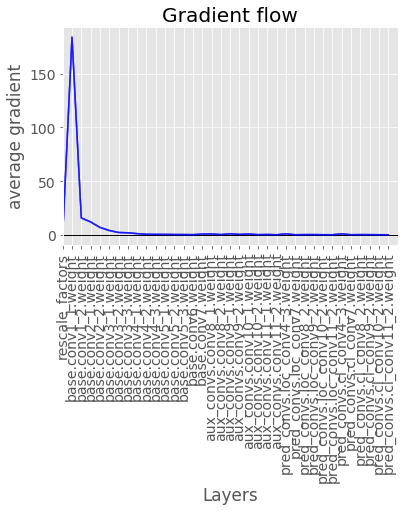

In [29]:
main()

# eval.py

In [30]:
from pprint import PrettyPrinter

In [31]:
pp = PrettyPrinter()

In [32]:
checkpoint = "checkpoint_ssd300.pth.tar"
checkpoint = torch.load(checkpoint)
model = SSD300(n_classes)
model.load_state_dict(checkpoint['model_state'])
model = model.to(device)
model = model.eval()

Decimating Tensor of shape:  torch.Size([4096, 512, 7, 7])
Decimated to Tensor of shape:  torch.Size([1024, 512, 3, 3])
Decimating Tensor of shape:  torch.Size([4096])
Decimated to Tensor of shape:  torch.Size([1024])
Decimating Tensor of shape:  torch.Size([4096, 4096, 1, 1])
Decimated to Tensor of shape:  torch.Size([1024, 1024, 1, 1])
Decimating Tensor of shape:  torch.Size([4096])
Decimated to Tensor of shape:  torch.Size([1024])
BASE MODEL LOAD....COMPLETE



In [33]:
test_dataset = PascalVOCDataset(data_folder, split="test", keep_diffcult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                        shuffle=False, collate_fn=test_dataset.collate_fn,
                                          num_workers=num_workers, pin_memory=pin_memory)

In [34]:
def evaluate(test_loader, model):
    model.eval()
    
    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    true_difficulties = list()
    
    with torch.no_grad():
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc='Evaluating')):
            images = images.to(device)
            predicted_locs, predicted_scores = model(images)
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                      min_score=0.01,
                                                                                      max_overlap=0.45,
                                                                                      top_k=200)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]
            
            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)
        
        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)
    
    pp.pprint(APs)
    print("\nMean Average Precision (mAP): {}".format(mAP))

In [ ]:
evaluate(test_loader, model)

# detect.py

In [ ]:
from torchvision.transforms import transforms
from PIL import Image, ImageDraw, ImageFont
def detect(model, original_image, min_score, max_overlap, top_k, suppress=None):
    resize = transforms.Resize((300,300))
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    
    image = normalize(to_tensor(resize(original_image)))
    image = image.to(device)
    
    predicted_locs, predicted_scores = model(image.unsqueeze(0))
    
    det_boxes, det_labels, det_scores = model.detect_objects(
        predicted_locs, predicted_scores,min_score=min_score, max_overlap=max_overlap, top_k=top_k)
    det_boxes = det_boxes[0].to('cpu')
    
    original_dims = torch.FloatTensor([original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims
    
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]
    
    if det_labels == ['background']:
        return original_image
    
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("./calibri.ttf", 15)
    
    
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue
        
        box_location = det_boxes[i].tolist()
        
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l+1.0 for l in box_location], outline=label_color_map[det_labels[i]])
        
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0]+2., box_location[1]-text_size[1]]
        textbox_location = [box_location[0], box_location[1]-text_size[1],
                            box_location[0]+text_size[0]+4., box_location[1]]
        
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white', font=font)
        print(det_labels[i])
    
    del draw
    
    return annotated_image

In [ ]:
image_path = "./train/VOC2007/JPEGImages/000012.jpg"
original_image = Image.open(image_path, mode='r')
original_image = original_image.convert('RGB')

detect(model, original_image, min_score=0.25, max_overlap=0.5, top_k=200).show()

In [ ]:
"A".upper()

In [ ]:
# ### TESTING FACILITIES###
# mu.clear_cuda()
# train_dataset = PascalVOCDataset('./', split='train', keep_diffcult=True)
# train_loader = DataLoader(train_dataset, batch_size=3, collate_fn=train_dataset.collate_fn, num_workers=4, pin_memory=False)
# vggbase = VGGBase()
# auxconv = AuxiliaryConvolutions()
# prdconv = PredictionConvolutions(len(label_map))
# model = SSD300(len(label_map))
# model = model.to(device)
# criterion = MultiBoxLoss(model.priors_cxcy).to(device)
# opt = optim.Adam(model.parameters())
# for i, (images, boxes, labels, _) in enumerate(train_loader):
#     images = images.to(device)
# #     print(images.shape)
# #     print(len(boxes))
# #     print(len(labels))
# #     print(len(_))
# #     out4_3, out7 = vggbase(images)
# #     print(out4_3.shape)
# #     print(out7.shape)
# #     out8_2, out9_2, out10_2, out11_2 = auxconv(out7)
# #     print(out8_2.shape)
# #     print(out9_2.shape)
# #     print(out10_2.shape)
# #     print(out11_2.shape)
#     opt.zero_grad()
#     locs, class_scores = model(images)
# #     print(locs.shape)
# #     print(class_scores.shape)
#     boxes = [b.to(device) for b in boxes]
#     labels = [l.to(device) for l in labels]
#     loss = criterion(locs, class_scores, boxes, labels)
#     loss.backward()
#     opt.step()
#     print(loss.item())
    
#     if i==3:
#         break